loading the data


In [1]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
from google.colab import files
import pandas as pd
import io

# Upload the file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the file into a pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display the first 5 rows
print(df.head())

Saving Mall_Customers.csv to Mall_Customers.csv
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
# prompt: change the format of gender in numerical format

gender_mapping = {'Male': 0, 'Female': 1}  # Or any other mapping you prefer
df['Gender'] = df['Gender'].map(gender_mapping)

print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       0   19                  15                      39
1           2       0   21                  15                      81
2           3       1   20                  16                       6
3           4       1   23                  16                      77
4           5       1   31                  17                      40


In [5]:
# prompt: split numeric and categorical variables

numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
Categorical columns: Index([], dtype='object')


preprocesing


In [6]:
# prompt: detect missing values

missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [7]:
# prompt: detect outliers and remove them

import numpy as np

def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_filtered


for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       0   19                  15                      39
1           2       0   21                  15                      81
2           3       1   20                  16                       6
3           4       1   23                  16                      77
4           5       1   31                  17                      40


In [8]:
# prompt: detect null values

null_values = df.isnull().sum()
print("Null values in each column:\n", null_values)


Null values in each column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the 'Annual Income (k$)' and 'Spending Score (1-100)' columns
df[['Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(df[['Annual Income (k$)', 'Spending Score (1-100)']])

# Display the standardized data
print(df.head())


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1       0   19           -1.779171               -0.435989   
1           2       0   21           -1.779171                1.199413   
2           3       1   20           -1.739447               -1.720949   
3           4       1   23           -1.739447                1.043661   
4           5       1   31           -1.699723               -0.397051   

   Cluster  
0        0  
1        2  
2        0  
3        2  
4        0  


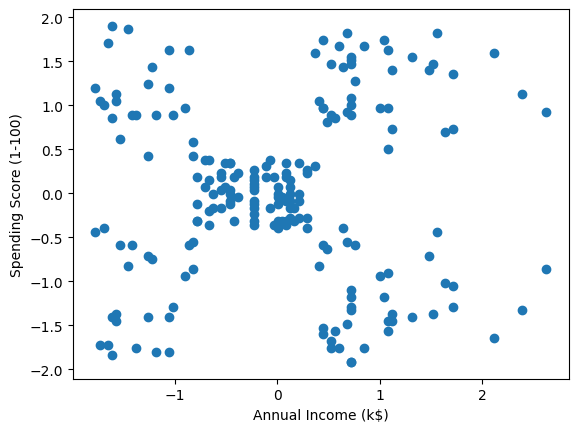

In [18]:
import matplotlib.pyplot as plt
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


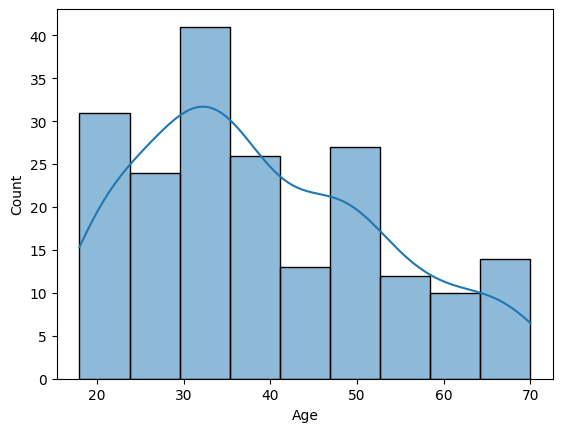

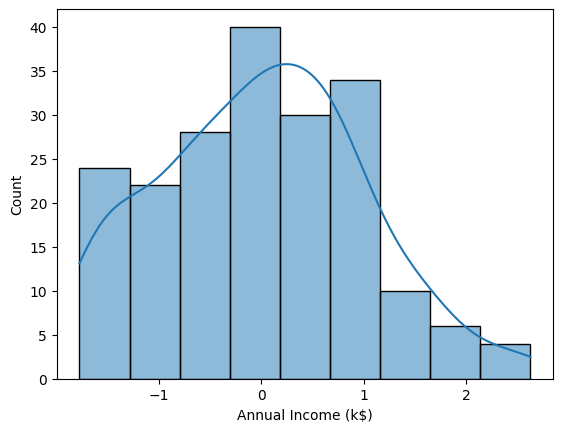

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Age Histogarm
sns.histplot(df['Age'], kde=True)
plt.show()

# Annual Income Histogarm
sns.histplot(df['Annual Income (k$)'], kde=True)
plt.show()



Modelling

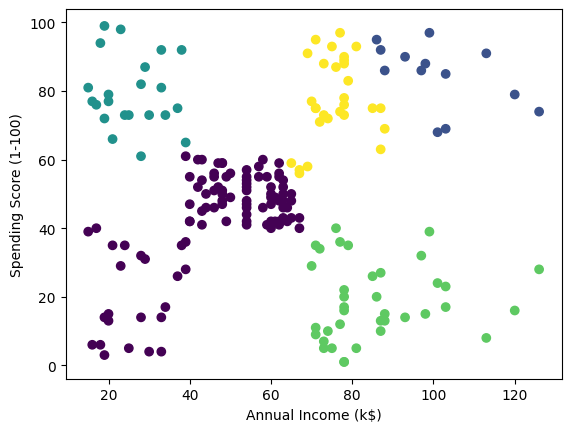

In [11]:
from sklearn.cluster import KMeans

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], c=df['Cluster'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


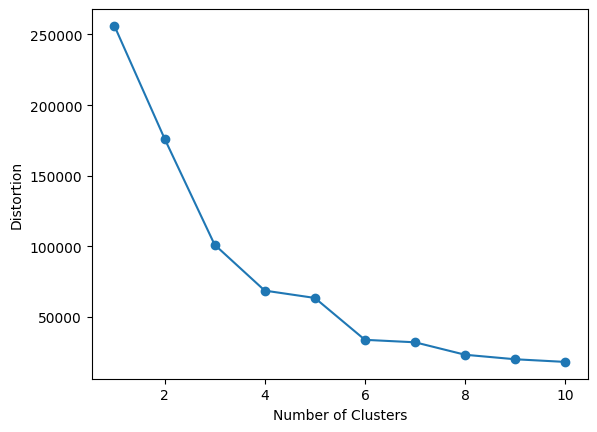

In [12]:
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()


In [13]:
from sklearn.cluster import KMeans

# Running K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Adding cluster labels to the main dataset
df['Cluster'] = y_kmeans

# Displaying the cluster labels
print(df.head())



   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1       0   19                  15                      39   
1           2       0   21                  15                      81   
2           3       1   20                  16                       6   
3           4       1   23                  16                      77   
4           5       1   31                  17                      40   

   Cluster  
0        0  
1        2  
2        0  
3        2  
4        0  


In [14]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


         CustomerID    Gender        Age  Annual Income (k$)  \
Cluster                                                        
0         68.412371  0.587629  43.690722           47.391753   
1        185.230769  0.615385  32.769231          101.076923   
2         23.090909  0.590909  25.272727           25.727273   
3        161.000000  0.486486  40.621622           85.648649   
4        144.551724  0.551724  33.965517           75.586207   

         Spending Score (1-100)  
Cluster                          
0                     42.814433  
1                     84.615385  
2                     79.363636  
3                     18.648649  
4                     77.586207  


In [20]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for the chosen K (e.g., 5 clusters)
score = silhouette_score(X, df['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.4364591140474929


Model improvement

In [21]:
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'Silhouette Score for {n_clusters} clusters: {score}')


Silhouette Score for 2 clusters: 0.3871155777204612
Silhouette Score for 3 clusters: 0.46541758070184547
Silhouette Score for 4 clusters: 0.4978912314482624
Silhouette Score for 5 clusters: 0.4364591140474929
Silhouette Score for 6 clusters: 0.540179791500928
Silhouette Score for 7 clusters: 0.5103267110757933


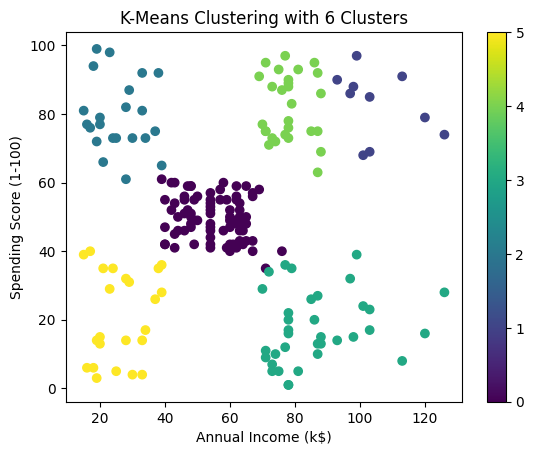

In [22]:
# Re-run K-Means with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Scatter plot with 6 clusters
plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-Means Clustering with 6 Clusters')
plt.colorbar()
plt.show()


In [23]:
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)


         CustomerID    Gender        Age  Annual Income (k$)  \
Cluster                                                        
0         85.737500  0.587500  42.937500           -0.186720   
1        189.000000  0.600000  32.700000            1.807942   
2         23.090909  0.590909  25.272727           -1.353037   
3        162.485714  0.485714  40.914286            1.054880   
4        151.000000  0.535714  32.785714            0.724884   
5         23.000000  0.608696  45.217391           -1.330113   

         Spending Score (1-100)  
Cluster                          
0                     -0.018864  
1                      1.265608  
2                      1.135696  
3                     -1.270379  
4                      1.234180  
5                     -1.140262  


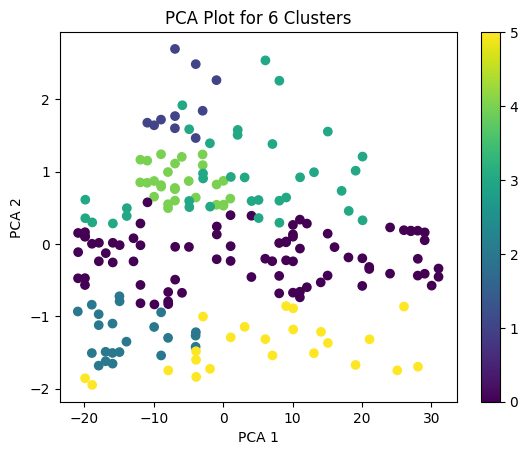

In [24]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Plot for 6 Clusters')
plt.colorbar()
plt.show()


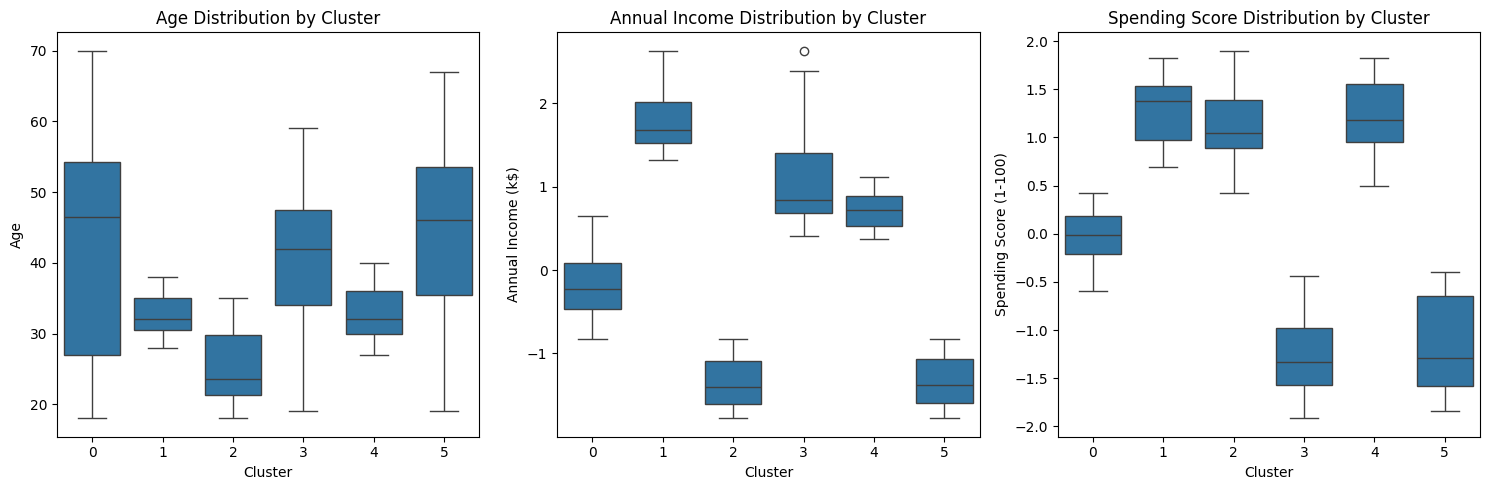

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots to compare distributions between clusters
plt.figure(figsize=(15, 5))

# Box plot for Age distribution
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

# Box plot for Annual Income distribution
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Annual Income (k$)', data=df)
plt.title('Annual Income Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Annual Income (k$)')

# Box plot for Spending Score distribution
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=df)
plt.title('Spending Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spending Score (1-100)')

# Show all plots
plt.tight_layout()
plt.show()
